In [1]:
import sklearn.metrics as skm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from analysis_utils import *
from nlp_synt_data import *
from data.texts import *
from data.training import *
from sc import *

/Users/tommasoromano/Documents/websites/unimi-language-detection/analysis_utils.py:475: SyntaxWarning: invalid escape sequence '\*'
  _dfs.append((df_job[df_job['text_JOB_value'].str.contains("\*")], nm+"_star"))


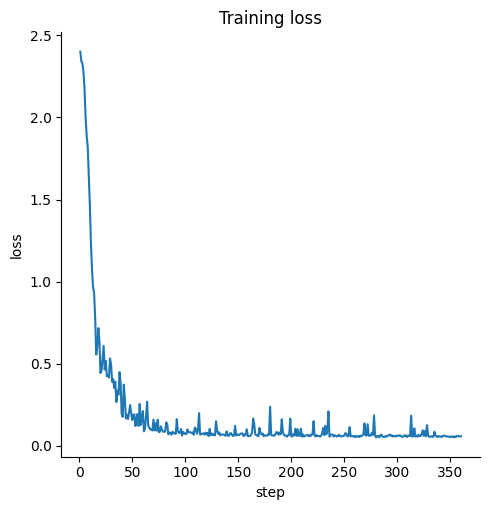

In [2]:
df_loss = pd.DataFrame({
    'step': [int(ln.split('	')[0]) for ln in TRAINING_LOSS.split('\n')],
    'loss': [float(ln.split('	')[1]) for ln in TRAINING_LOSS.split('\n')],
})
sns.relplot(data=df_loss, x='step', y='loss', kind='line')
plt.title('Training loss')
plt.show()

In [3]:
pd.read_csv(sc_csv_name("phi3", False, False))

,prompt_id,text,text_labels,response,text_JOB_value,text_ADJ_value,text_JOB_label,text_ADJ_label
0,zsl#0,"tnservice srl, agenzia per il lavoro (aut. min...",INCLUSIVO,INCLUSIVO,NaN,NaN,NaN,NaN
1,zsl#0,per nostro cliente specializzato nel settore t...,TODO,INCLUSIVO,giornaista,NaN,neutro,NaN
2,zsl#0,per nostro cliente specializzato nel settore t...,TODO,"INCLUSIVO\n\n\nLa frase ""per nostro cliente s...",autista,NaN,neutro,NaN
3,zsl#0,per nostro cliente specializzato nel settore t...,TODO,INCLUSIVO,dentista,NaN,neutro,NaN
4,zsl#0,per nostro cliente specializzato nel settore t...,TODO,INCLUSIVO,ginnasta,NaN,neutro,NaN
...,...,...,...,...,...,...,...,...
10419,fsl#0,Il profilo ideale è addetta che: \nHa consegui...,TODO,INCLUSIVO,addetta,NaN,femminile,NaN
10420,fsl#0,Il profilo ideale è addett* che: \nHa consegui...,TODO,INCLUSIVO,addett*,NaN,neutro,NaN
10421,fsl#0,Il profilo ideale è addetto/a che: \nHa conseg...,TODO,INCLUSIVO,addetto/a,NaN,neutro,NaN
10422,fsl#0,Il profilo ideale è consultant che: \nHa conse...,TODO,INCLUSIVO,consultant,NaN,neutro,NaN


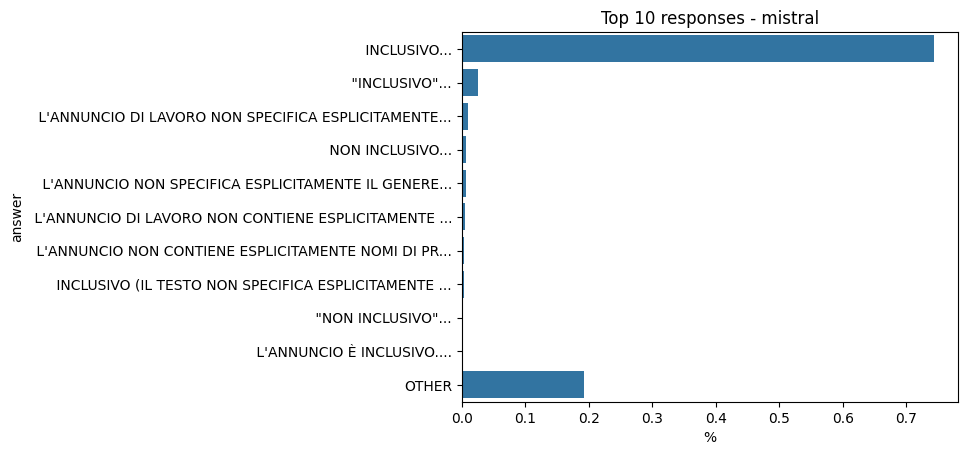

Fixed 0.03, 283 rows


['INCLUSIVO', 'NON INCLUSIVO']

In [4]:
df = pd.read_csv(sc_csv_name("mistral", False, False))
df = fix_df(df)
df = fix_df_model_response(df, 'mistral')
df['response'].unique().tolist()

phi3-finetuned


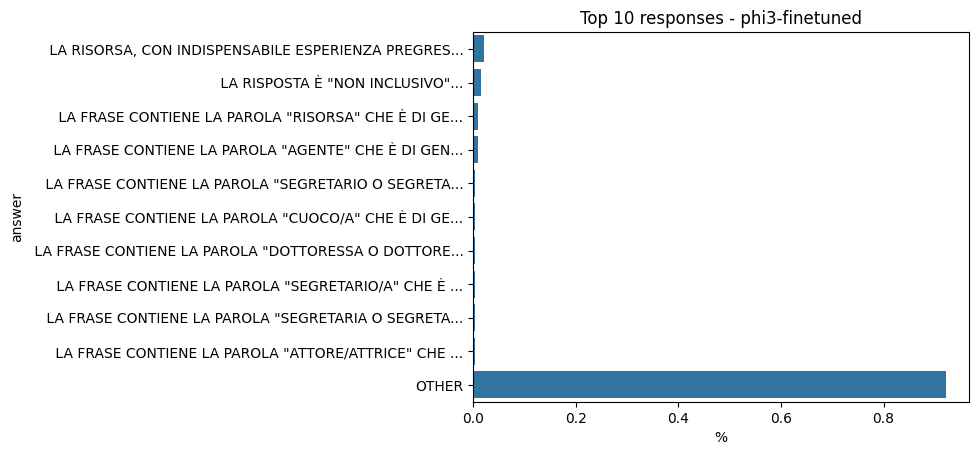

Fixed 0.02, 242 rows
gpt-4o-mini


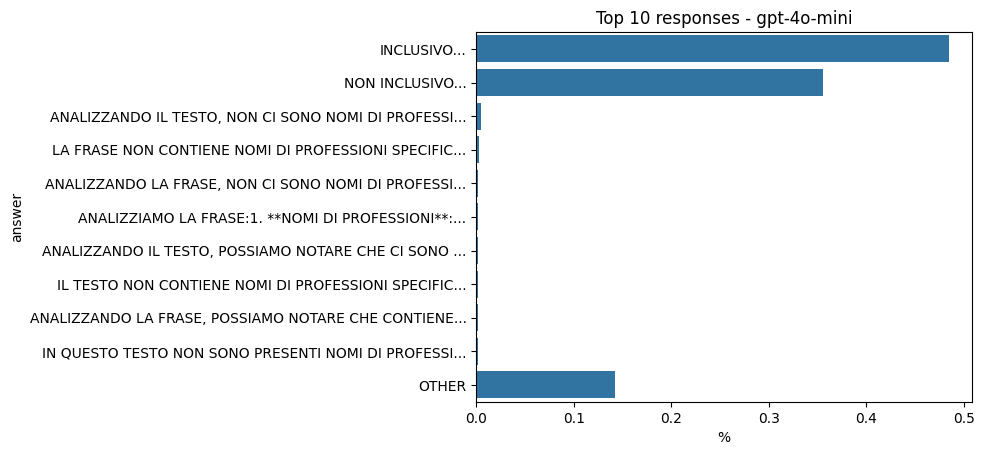

Fixed 0.0, 2 rows
phi3


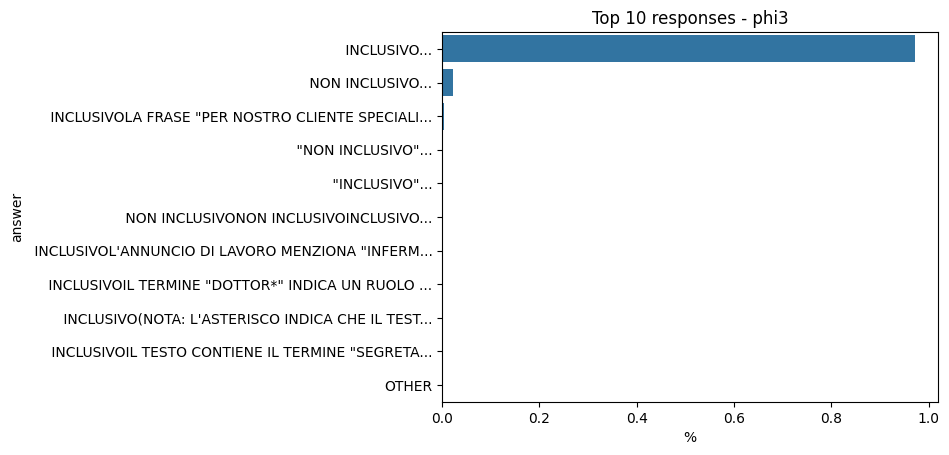

Fixed 0.0, 0 rows
llama3


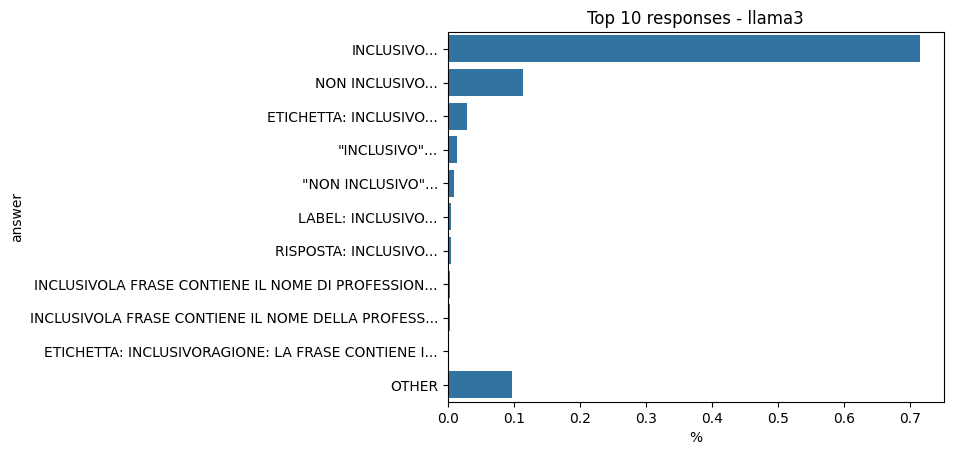

Fixed 0.0, 1 rows
mistral


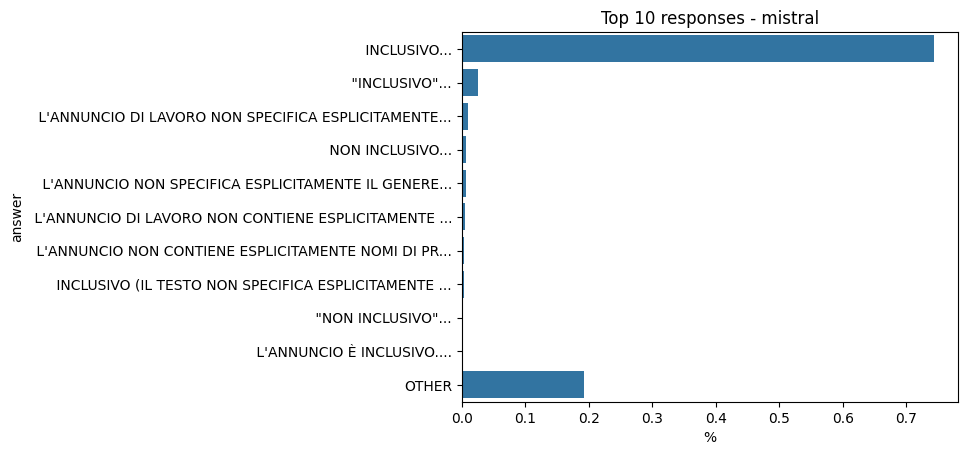

Fixed 0.03, 283 rows
gemma2


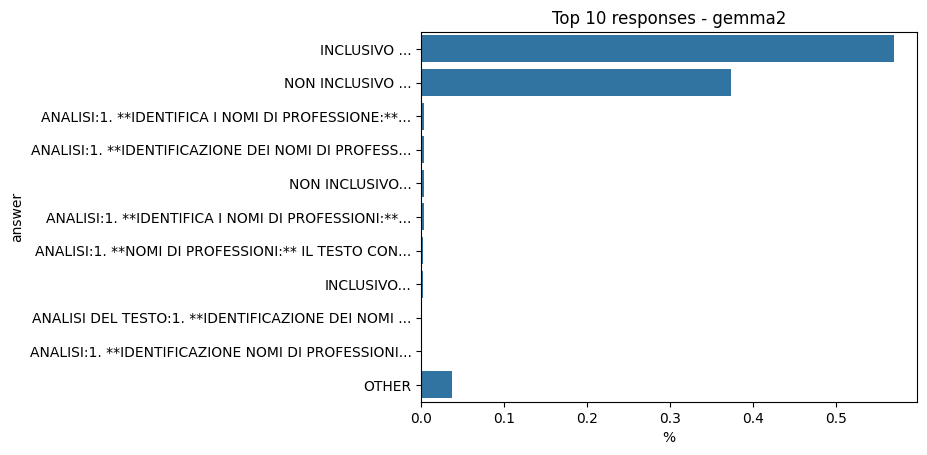

Fixed 0.0, 9 rows
qwen2


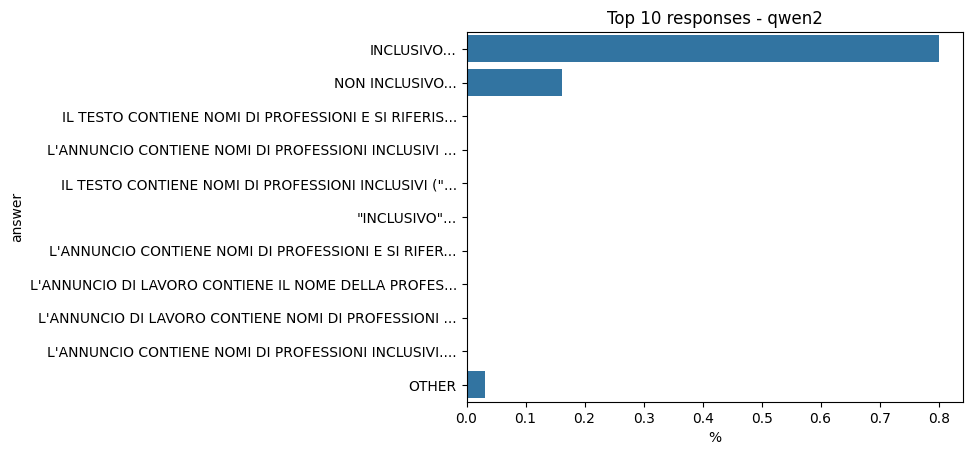

Fixed 0.0, 22 rows


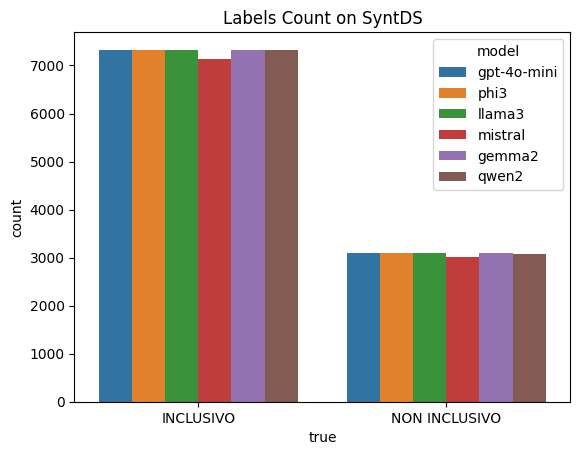

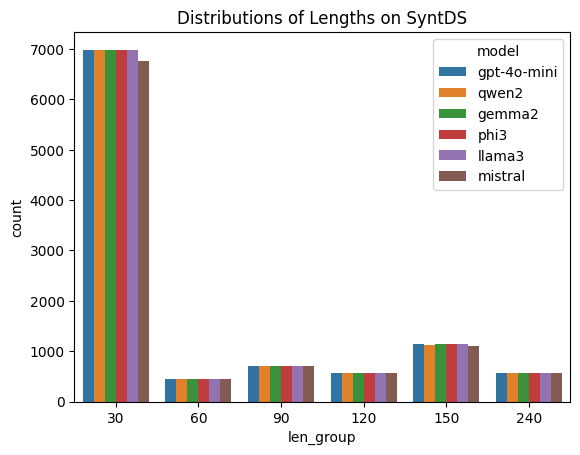

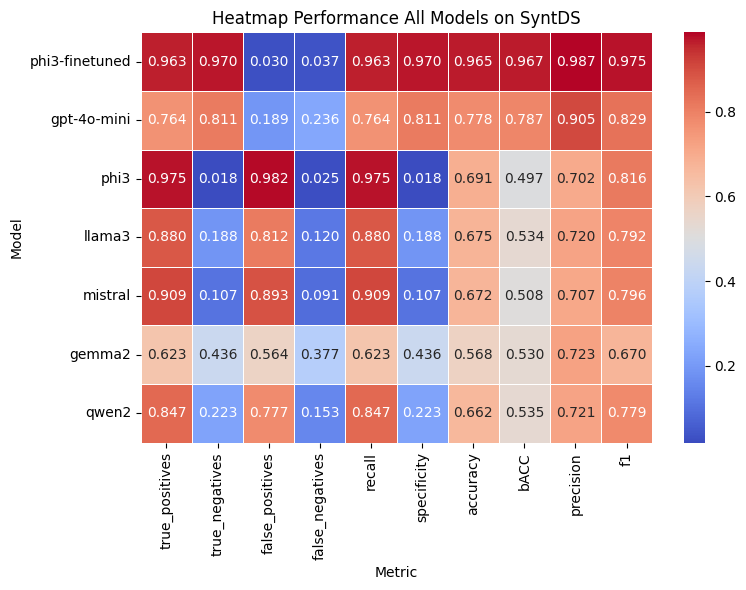

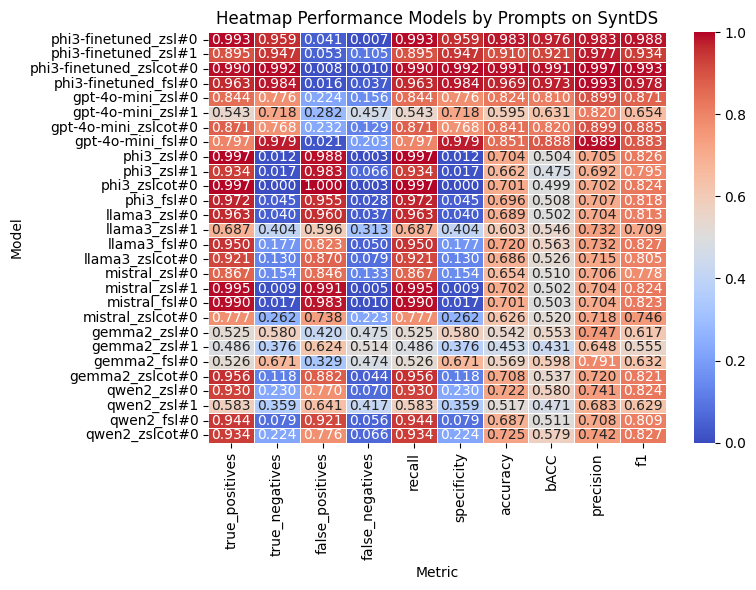

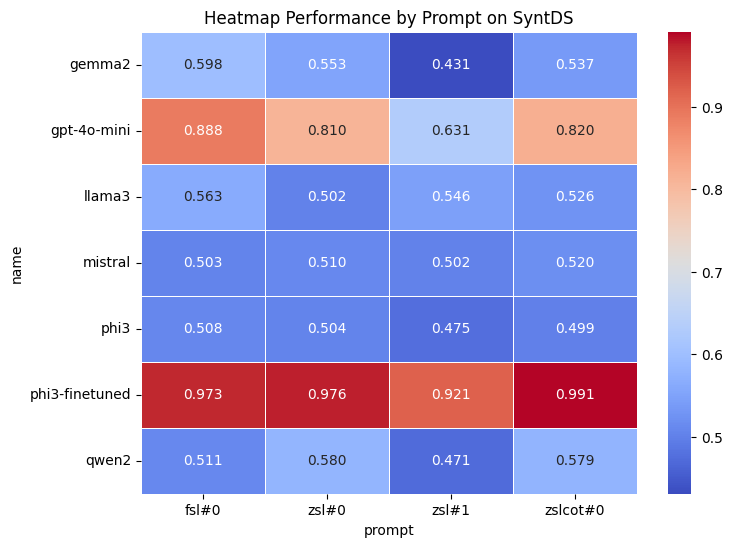

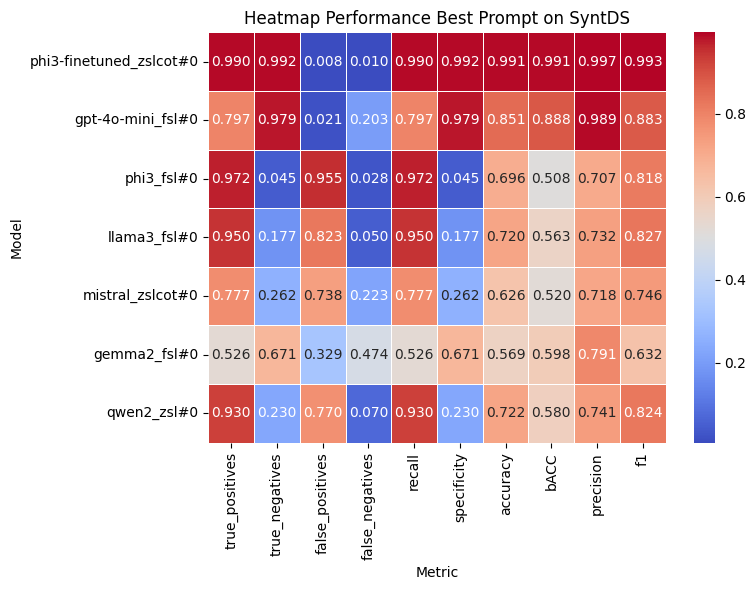

/Users/tommasoromano/Documents/websites/unimi-language-detection/analysis_utils.py:247: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])


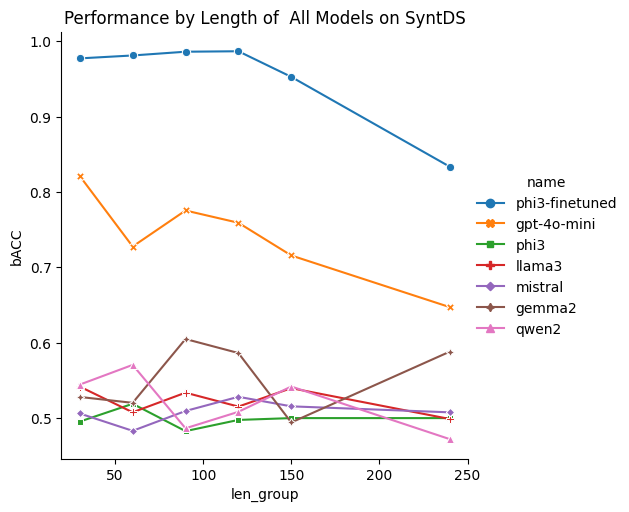

/Users/tommasoromano/Documents/websites/unimi-language-detection/analysis_utils.py:247: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])


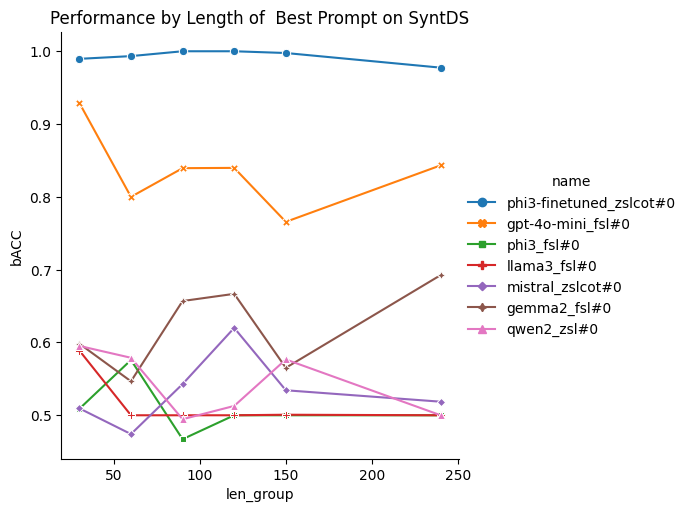

/Users/tommasoromano/Documents/websites/unimi-language-detection/analysis_utils.py:247: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])


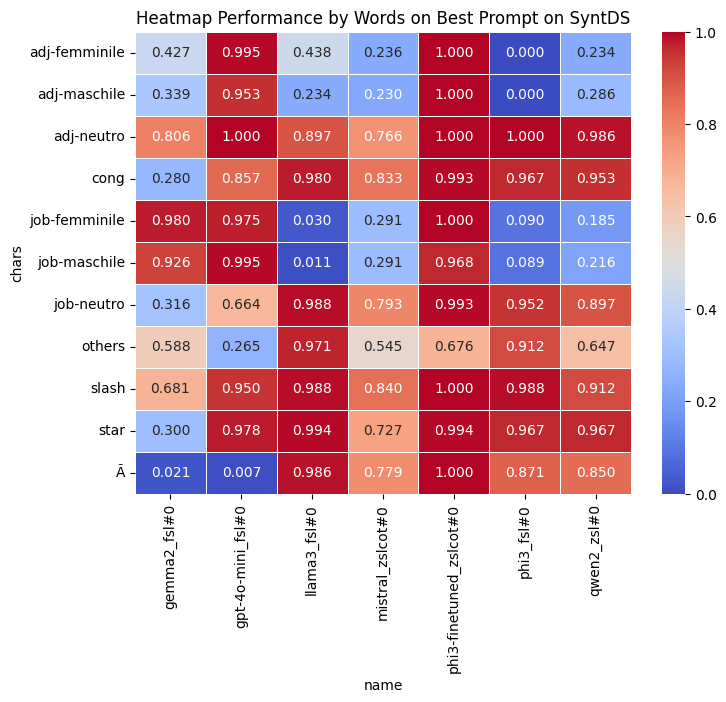

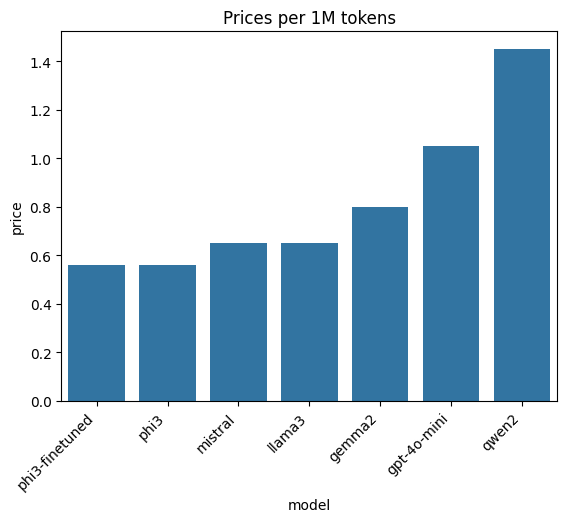

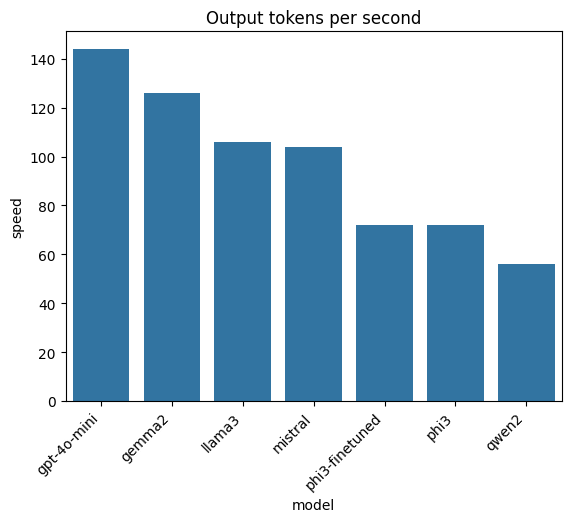

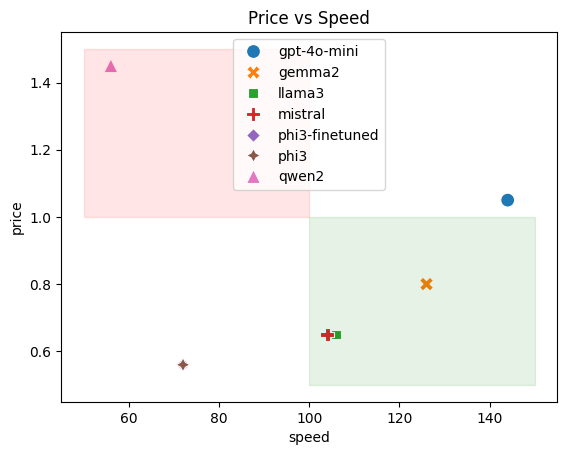

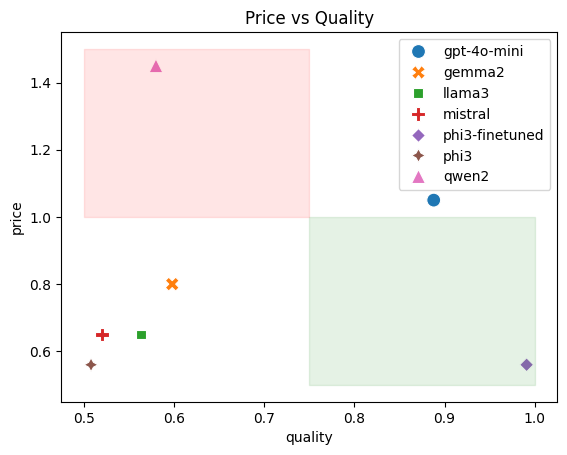

AssertionError: 

In [5]:
IS_SEED = False
ds_text = " on SyntDS" if not IS_SEED else " on RealDS"

dfs_all ,dfs_by_len ,dfs_by_prompt ,dfs_by_pl = make_all_dfs(is_seed=IS_SEED)

df_all = merge_dfs(dfs_all)
df_all_not_finetuned = merge_dfs([x for x in dfs_all if 'finetuned' not in x[1]])
# df_by_len = merge_dfs(dfs_by_len)
# df_by_prompt = merge_dfs(dfs_by_prompt)

plot_labels_by_model(df_all_not_finetuned, title=ds_text)
plot_len_groups(df_all_not_finetuned, title=ds_text)

heatmap_of_performance(dfs_all, title=" All Models" + ds_text)
heatmap_of_performance(dfs_by_prompt, title=" Models by Prompts" + ds_text)
# plot_prompts(dfs_by_prompt, title=ds_text)
heatmap_of_prompts(dfs_by_prompt, title=ds_text)
best_prompts = get_best_prompt(dfs_by_prompt)
dfs_best_all = [(df,nm) for df,nm in dfs_by_prompt if best_prompts[nm.split('_')[0]][0] in nm]
dfs_best_by_len = [(df,nm) for df,nm in dfs_by_pl if best_prompts[nm.split('_')[0]][0] in nm]
heatmap_of_performance(dfs_best_all, title=" Best Prompt" + ds_text)
# heatmap_of_performance(dfs_by_len, title="Models by Length" + ds_text)
plot_len_metrics(dfs_by_len, 1, title=" All Models" + ds_text)
# heatmap_of_performance(dfs_best_by_len, title="Best Prompts by Length" + ds_text)
plot_len_metrics(dfs_best_by_len, 2, title=" Best Prompt" + ds_text)
# heatmap_of_performance(dfs_by_pl, title=" Models by Prompt and Length" + ds_text)
# plot_len_metrics(dfs_by_pl, "precision", 2, title="Models by Prompt and Length" + ds_text)

if not IS_SEED:
    heatmap_of_chars(dfs_best_all, title=" on Best Prompt" + ds_text, metric_col="accuracy")

plot_general_costs()

assert 1 == 2

In [ ]:
assert 1 == 2

AssertionError: 